<a href="https://colab.research.google.com/github/anjandhungana/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 11.2: Residual Networks**

This notebook adapts the networks for MNIST1D to use residual connections.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-3597h335
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-3597h335
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=6b05add073772e875d4a6555db0edddbe88a98e3ea58fd8377e447f4b4182294
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_dt0yua/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [6]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

# TODO -- Add residual connections to this model
# The order of operations within each block should similar to figure 11.5b
# ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# Replace this function
  def forward(self, x):
    h1 = self.linear1(x).relu()
    h2 = self.linear2(h1).relu() + h1 # Residual connection 1
    h3 = self.linear3(h2).relu() + h2 # Residual connection 2
    return self.linear4(h3)

In [7]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [8]:
#Define the model
model = ResidualNetwork(40, 10)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.655367, train error 63.97,  val loss 1.696621, percent error 66.70
Epoch     1, train loss 1.379142, train error 51.62,  val loss 1.486061, percent error 58.40
Epoch     2, train loss 1.141091, train error 41.40,  val loss 1.306927, percent error 49.50
Epoch     3, train loss 1.007330, train error 36.80,  val loss 1.227266, percent error 46.30
Epoch     4, train loss 0.898661, train error 32.40,  val loss 1.180762, percent error 45.20
Epoch     5, train loss 0.817707, train error 30.22,  val loss 1.129889, percent error 43.30
Epoch     6, train loss 0.719687, train error 26.60,  val loss 1.066304, percent error 41.20
Epoch     7, train loss 0.685368, train error 25.35,  val loss 1.153923, percent error 41.40
Epoch     8, train loss 0.648092, train error 23.88,  val loss 1.164665, percent error 42.90
Epoch     9, train loss 0.595647, train error 22.90,  val loss 1.171943, percent error 40.40
Epoch    10, train los

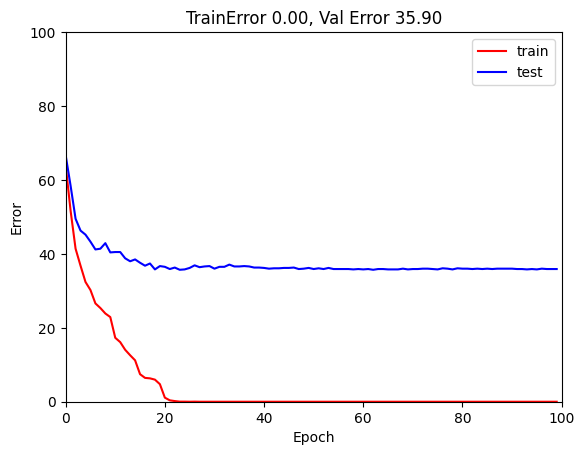

In [9]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()

The primary motivation of residual networks is to allow training of much deeper networks.   

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?

In [ ]:
# The primary motivation of residual networks is to allow training of much deeper networks.

# TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?

# Task
Modify the `ResidualNetwork` class to include a parameter to enable or disable residual connections. Then, train the network with and without residual connections and plot the training and validation errors for comparison.

## Modify network class

### Subtask:
Add a parameter to the `ResidualNetwork` class to enable or disable residual connections.


**Reasoning**:
Modify the ResidualNetwork class to include a parameter to enable or disable residual connections in the forward method based on the provided instructions.



In [10]:
class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100, use_residuals=True):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    self.use_residuals = use_residuals
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.linear1(x).relu()
    if self.use_residuals:
        h2 = self.linear2(h1).relu() + h1 # Residual connection 1
        h3 = self.linear3(h2).relu() + h2 # Residual connection 2
    else:
        h2 = self.linear2(h1).relu() # No Residual connection 1
        h3 = self.linear3(h2).relu() # No Residual connection 2

    return self.linear4(h3)

## Train without residuals

### Subtask:
Instantiate the network with residual connections disabled and train it. Store the training and validation errors.


**Reasoning**:
The goal is to train the network without residual connections. This requires instantiating the model with `use_residuals=False`, setting up the training infrastructure (loss function, optimizer, scheduler, data loader), initializing the weights, and then running the training loop for the specified number of epochs while recording the training and validation performance metrics. This can all be done in a single code block.



In [11]:
# Define the model without residual connections
model_no_residuals = ResidualNetwork(40, 10, use_residuals=False)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer_no_residuals = torch.optim.SGD(model_no_residuals.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler_no_residuals = StepLR(optimizer_no_residuals, step_size=20, gamma=0.5)
# convert data to torch tensors
# These are already converted in a previous cell, no need to convert again.
# x_train = torch.tensor(train_data_x.transpose().astype('float32'))
# y_train = torch.tensor(train_data_y.astype('long'))
# x_val= torch.tensor(val_data_x.transpose().astype('float32'))
# y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model_no_residuals.apply(weights_init)

# loop over the dataset n_epoch times
# n_epoch is already defined as 100
# store the loss and the % correct at each epoch
losses_train_no_residuals = np.zeros((n_epoch))
errors_train_no_residuals = np.zeros((n_epoch))
losses_val_no_residuals = np.zeros((n_epoch))
errors_val_no_residuals = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer_no_residuals.zero_grad()
    # forward pass -- calculate model output
    pred = model_no_residuals(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer_no_residuals.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model_no_residuals(x_train)
  pred_val = model_no_residuals(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train_no_residuals[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val_no_residuals[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train_no_residuals[epoch] = loss_function(pred_train, y_train).item()
  losses_val_no_residuals[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_no_residuals[epoch]:.6f}, train error {errors_train_no_residuals[epoch]:3.2f},  val loss {losses_val_no_residuals[epoch]:.6f}, percent error {errors_val_no_residuals[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler_no_residuals.step()

Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.605309, train error 62.30,  val loss 1.686068, percent error 67.50
Epoch     1, train loss 1.339615, train error 50.72,  val loss 1.489556, percent error 58.70
Epoch     2, train loss 1.167214, train error 43.20,  val loss 1.387896, percent error 56.60
Epoch     3, train loss 1.004917, train error 36.65,  val loss 1.298886, percent error 49.40
Epoch     4, train loss 0.858159, train error 31.35,  val loss 1.234278, percent error 46.60
Epoch     5, train loss 0.718187, train error 26.10,  val loss 1.188483, percent error 45.70
Epoch     6, train loss 0.610009, train error 21.97,  val loss 1.148386, percent error 40.40
Epoch     7, train loss 0.512362, train error 17.88,  val loss 1.199038, percent error 42.90
Epoch     8, train loss 0.486959, train error 16.50,  val loss 1.242278, percent error 44.40
Epoch     9, train loss 0.408725, train error 14.93,  val loss 1.179461, percent error 40.00
Epoch    10, train los

## Train with residuals

### Subtask:
Instantiate the network with residual connections enabled and train it. Store the training and validation errors.


**Reasoning**:
Instantiate and train the network with residual connections enabled, storing the training and validation errors.



In [12]:
# Instantiate the network with residual connections enabled
model_with_residuals = ResidualNetwork(40, 10, use_residuals=True)

# Define a new SGD optimizer for model_with_residuals
optimizer_with_residuals = torch.optim.SGD(model_with_residuals.parameters(), lr = 0.05, momentum=0.9)

# Define a new learning rate scheduler
scheduler_with_residuals = StepLR(optimizer_with_residuals, step_size=20, gamma=0.5)

# Initialize weights
model_with_residuals.apply(weights_init)

# Initialize arrays to store results
losses_train_with_residuals = np.zeros((n_epoch))
errors_train_with_residuals = np.zeros((n_epoch))
losses_val_with_residuals = np.zeros((n_epoch))
errors_val_with_residuals = np.zeros((n_epoch))

# Training loop
for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer_with_residuals.zero_grad()
    # forward pass -- calculate model output
    pred = model_with_residuals(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer_with_residuals.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model_with_residuals(x_train)
  pred_val = model_with_residuals(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train_with_residuals[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val_with_residuals[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train_with_residuals[epoch] = loss_function(pred_train, y_train).item()
  losses_val_with_residuals[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_with_residuals[epoch]:.6f}, train error {errors_train_with_residuals[epoch]:3.2f},  val loss {losses_val_with_residuals[epoch]:.6f}, percent error {errors_val_with_residuals[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler_with_residuals.step()

Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.582303, train error 59.45,  val loss 1.688680, percent error 65.90
Epoch     1, train loss 1.288029, train error 46.88,  val loss 1.450240, percent error 56.90
Epoch     2, train loss 1.102558, train error 40.20,  val loss 1.322867, percent error 53.20
Epoch     3, train loss 0.982659, train error 37.28,  val loss 1.241792, percent error 48.60
Epoch     4, train loss 0.882829, train error 32.30,  val loss 1.188022, percent error 46.80
Epoch     5, train loss 0.771037, train error 27.57,  val loss 1.153515, percent error 43.80
Epoch     6, train loss 0.703808, train error 25.90,  val loss 1.133234, percent error 43.90
Epoch     7, train loss 0.628277, train error 22.60,  val loss 1.139803, percent error 43.40
Epoch     8, train loss 0.561121, train error 19.60,  val loss 1.102658, percent error 39.90
Epoch     9, train loss 0.537011, train error 18.60,  val loss 1.157227, percent error 39.30
Epoch    10, train los

## Visualize results

### Subtask:
Plot the training and validation errors for both cases (with and without residuals) on the same graph for comparison.


**Reasoning**:
Plot the training and validation errors for both cases (with and without residuals) on the same graph for comparison, following the instructions.



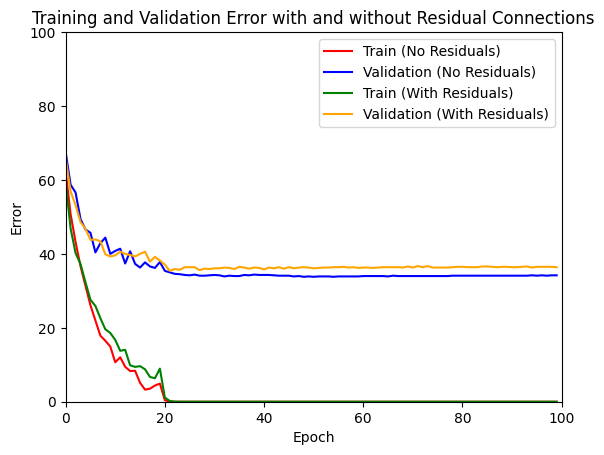

In [13]:
fig, ax = plt.subplots()
ax.plot(errors_train_no_residuals, 'r-', label='Train (No Residuals)')
ax.plot(errors_val_no_residuals, 'b-', label='Validation (No Residuals)')
ax.plot(errors_train_with_residuals, 'g-', label='Train (With Residuals)')
ax.plot(errors_val_with_residuals, 'orange', label='Validation (With Residuals)')
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_title('Training and Validation Error with and without Residual Connections')
ax.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The `ResidualNetwork` class was successfully modified to allow enabling or disabling residual connections via a `use_residuals` parameter.
*   Both the network trained without residuals and the network trained with residuals achieved 0% training error after 22 epochs.
*   The validation error for the network trained without residuals plateaued around 34% after the initial decrease.
*   The validation error for the network trained with residuals stabilized around 36-40% after epoch 17.

### Insights or Next Steps

*   While both networks quickly achieved perfect training accuracy, neither significantly improved performance on the validation set beyond a certain point, suggesting potential overfitting in both cases.
*   Future work could involve exploring regularization techniques or different network architectures to improve generalization performance and reduce the gap between training and validation error for both models.
